In [1]:
import os

from fastai.data.external import untar_data, URLs

import torch
import torchvision
from torch.utils.data import random_split

Downloading data

In [2]:
data_dir = "/kaggle/input/cifar10-synthetic/images"

Checking all the directories in the data downloaded and checking the classes 

In [3]:
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['Airplane', 'Horse', 'Truck', 'Automobile', 'Ship', 'Dog', 'Bird', 'Frog', 'Cat', 'Deer']


In [4]:
classes = os.listdir(data_dir + "/test")
print(classes)

['Airplane', 'Horse', 'Truck', 'Automobile', 'Ship', 'Dog', 'Bird', 'Frog', 'Cat', 'Deer']


Printing the names of the image files 

In [5]:
airplane_files = os.listdir(data_dir + "/train/Airplane")
print('No. of training examples for airplanes:', len(airplane_files))
print(airplane_files[:5])

No. of training examples for airplanes: 5500
['airliner_s_002037.png', 'dive_bomber_s_000386.png', 'stealth_fighter_s_001343.png', 'twinjet_s_000835.png', '016ep776_test_class_0.png']


In [6]:
ship_test_files = os.listdir(data_dir + "/test/Ship")
print("No. of test examples for ship:", len(ship_test_files))
print(ship_test_files[:5])

No. of test examples for ship: 1100
['small_boat_s_000425.png', 'tanker_s_002003.png', 'scow_s_000203.png', 'oil_tanker_s_000763.png', 'container_ship_s_001840.png']


Plotting random images from the dataset of each of the 10 classes 

In [7]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


Plots different images at every run

In [8]:
def show_images(dataset='train'):
    next_pix= []
    # Parameters for our graph; we'll output images in a 5x2 configuration
    nrows = 5
    ncols = 2

    fig = plt.gcf()
    fig.set_size_inches(ncols * 5, nrows * 5)
    for i in range(len(classes)):
        next_pix.append(os.path.join(data_dir,dataset,classes[i]))
        img = mpimg.imread(os.path.join(next_pix[i],random.choice(os.listdir(next_pix[i]))))
        # Set up subplot; subplot indices start at 1
        sp = plt.subplot(nrows, ncols, i + 1)
        sp.axis('Off') # Don't show axes (or gridlines)
        plt.imshow(img)
        plt.title(classes[i])

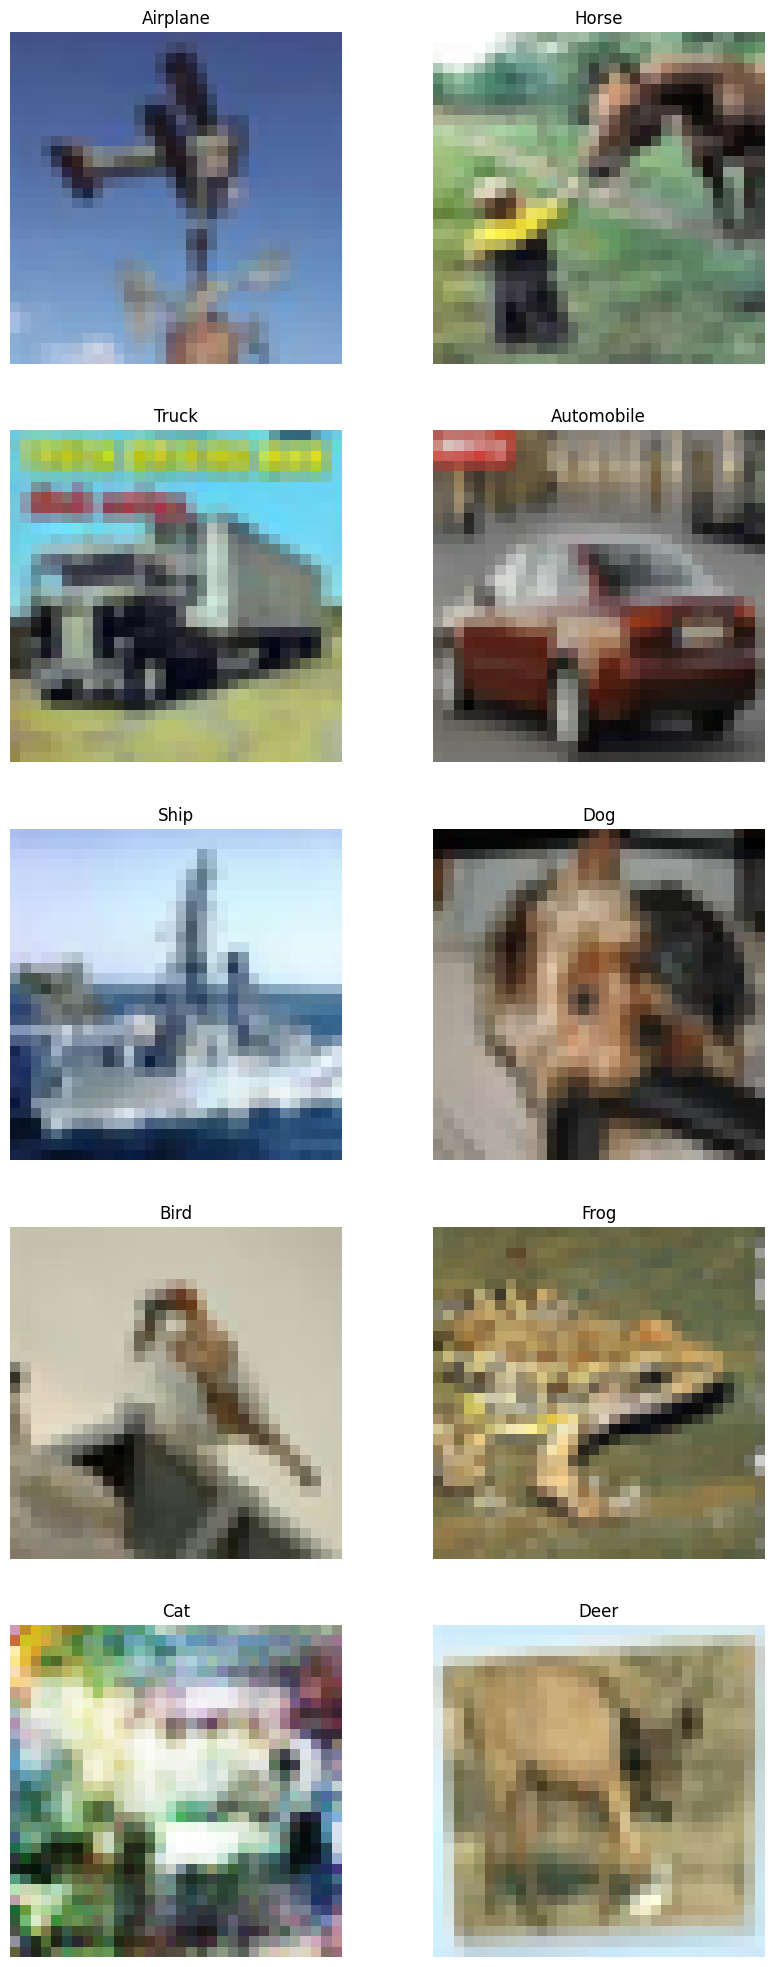

In [9]:
show_images('test')

Transofrming images to tensor

In [10]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

In [ ]:
dataset = ImageFolder(data_dir+'/train', transform=transforms.ToTensor())

In [ ]:
img, label = dataset[0]
print(img.shape, label)
img

In [ ]:
print(dataset.classes)

Changing tensor dimensions to h,w,c using permute. Permute shifts the channels

In [ ]:
def show_example(img, label):
    #print('Label: ', dataset.classes[label], "("+str(label)+")")
    print('Label No. : '+str(label))
    plt.title(dataset.classes[label])
    plt.imshow(img.permute(1, 2, 0))

  (*) sends tuple 

In [ ]:
show_example(*dataset[5949])

In [ ]:
show_example(*dataset[1049])

In [ ]:
random_seed = 42
torch.manual_seed(random_seed)

Splitting the dataset

In [ ]:
val_size = int(len(dataset)*0.10)
train_size = int(len(dataset) - val_size)  
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

Creating DataLoader to send images in batches

In [ ]:
from torch.utils.data.dataloader import DataLoader

batch_size=256

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

Making grid of a batch to check the dataset

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(30, 15))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

In [ ]:
show_batch(train_dl)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

using an example to get the output size of the the CNN to calculate the input size for the Linear after flattening

In [ ]:
simple_model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
)

In [ ]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

Defining functions for calculating accuracy and Loss

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)  
        return loss,acc
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['train_accuracy'], result['val_loss'], result['val_acc']))
        

Defining the CNN model

In [ ]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 4 x 4

            nn.Flatten(),
            nn.Dropout(p=0.3),
            nn.Linear(128*4*4, 128),
            nn.ReLU(),
            nn.Linear(128, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = Cifar10CnnModel()
model

Checking output of the model

In [ ]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

Installing torchinfo to check no. parameters of the layers

In [ ]:
pip install torchinfo

In [ ]:
from torchinfo import summary

summary(model, input_size=(batch_size, 3, 32, 32))

Checking the Device available and moving the model and dataset to that device

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

Defining the evaluation function and the fit function for backpropagation and model training

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func
    for epoch in (range(epochs)):
        # Training Phase 
        model.train()
        train_losses = []
        train_accuracy= []
        for (batch_idx, batch) in enumerate(train_loader):
            loss,accuracy = model.training_step(batch)
            train_losses.append(loss)
            train_accuracy.append(accuracy)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            if batch_idx % 50 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.4f}'.
                format(epoch+1, batch_idx , len(train_loader),
                       100. * batch_idx / len(train_loader), loss,accuracy))
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_accuracy'] = torch.stack(train_accuracy).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(Cifar10CnnModel(), device)

In [ ]:
evaluate(model, val_dl)

In [ ]:
num_epochs = 15
lr = 0.001
opt_func = torch.optim.Adam(model.parameters(),lr,amsgrad=True)

In [41]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [5], train_loss: 0.5178, train_acc: 0.8177, val_loss: 0.5811, val_acc: 0.7991
Train Epoch: 6 [0/194 (0%)]	Loss: 0.375930, Accuracy: 0.8516
Train Epoch: 6 [50/194 (26%)]	Loss: 0.453331, Accuracy: 0.8398
Train Epoch: 6 [100/194 (52%)]	Loss: 0.380992, Accuracy: 0.8594
Train Epoch: 6 [150/194 (77%)]	Loss: 0.532655, Accuracy: 0.8008
Epoch [6], train_loss: 0.4611, train_acc: 0.8383, val_loss: 0.6619, val_acc: 0.7725
Train Epoch: 7 [0/194 (0%)]	Loss: 0.358045, Accuracy: 0.8711
Train Epoch: 7 [50/194 (26%)]	Loss: 0.388342, Accuracy: 0.8633
Train Epoch: 7 [100/194 (52%)]	Loss: 0.567669, Accuracy: 0.8203
Train Epoch: 7 [150/194 (77%)]	Loss: 0.402499, Accuracy: 0.8477
Epoch [7], train_loss: 0.4105, train_acc: 0.8543, val_loss: 0.5893, val_acc: 0.7954
Train Epoch: 8 [0/194 (0%)]	Loss: 0.356300, Accuracy: 0.8828
Train Epoch: 8 [50/194 (26%)]	Loss: 0.395860, Accuracy: 0.8672
Train Epoch: 8 [100/194 (52%)]	Loss: 0.314327, Accuracy: 0.8828
Train Epoch: 8 [150/194 (77%)]	Loss: 0.343624, Accuracy:

In [42]:
def plot_accuracies(history):
    train_accuracies= [x['train_accuracy'] for x in history]
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-bx')
    plt.plot(train_accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Validation','Training'])
    plt.title('Accuracy vs. No. of epochs');

In [43]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

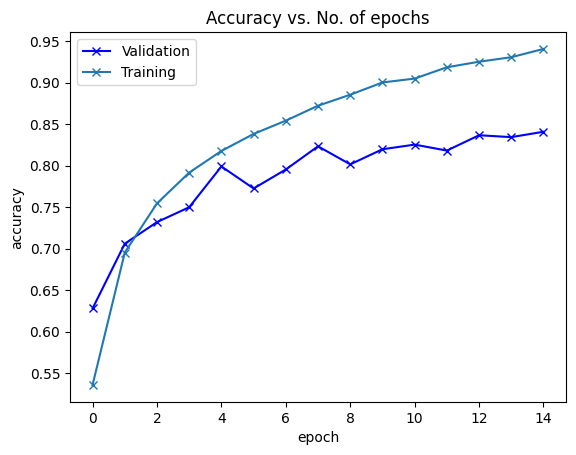

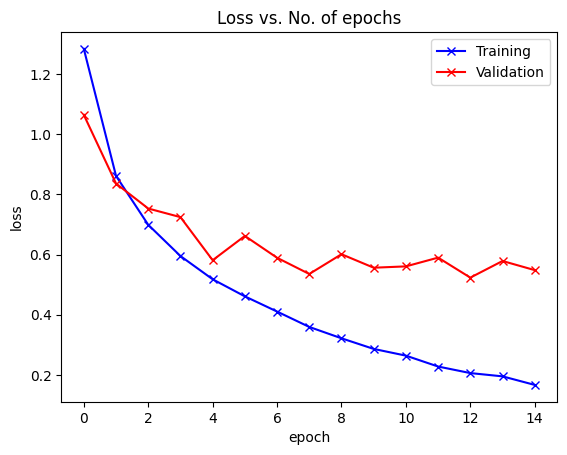

In [44]:
plot_accuracies(history)
plt.show()
plot_losses(history)

In [45]:
test_dataset = ImageFolder(data_dir+'/test', transform=transforms.ToTensor())

In [46]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.5773608088493347, 'val_acc': 0.8314212560653687}

Saving and Loading the model

In [47]:
torch.save(model.state_dict(), '/kaggle/working/cifar10-cnn.pth')

In [48]:
model2 = to_device(Cifar10CnnModel(), device)

In [49]:
model2.load_state_dict(torch.load('/kaggle/working/cifar10-cnn.pth'))

<All keys matched successfully>

Sanity Check

In [50]:
evaluate(model2, test_loader)

{'val_loss': 0.5773608088493347, 'val_acc': 0.8314212560653687}

Creating function for prediction of a single image

In [51]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    model.eval()
    with torch.no_grad():
        yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]


Label: Dog , Predicted: Dog


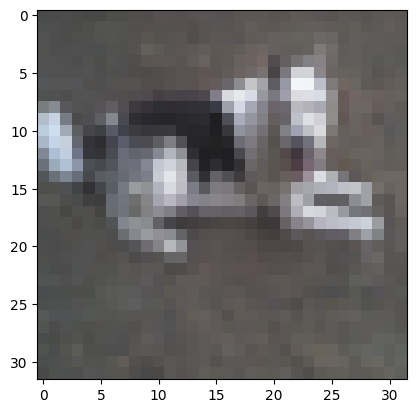

In [52]:
img, label = test_dataset[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))